<center><img src="https://javier.rodriguez.org.mx/itesm/2014/tecnologico-de-monterrey-blue.png" width="450" align="center"></center>
<br><p><center><h1><b>Monte Carlo Simulation for Financial Risk Assessment</b></h1></center></p> 
<p><center><h2><i>A Quantitative Analysis Approach to Estimating Value at Risk (VaR)</i></h2></center></p> 
<p><center><h3>Course: <i>Numerical Analysis for Non-Linear Optimization</i></h3></center></p>
<p><center><h4>Instructed by: <i>Dr. Juliho David Castillo Colmenares</i></h4></center></p> 

<p style="text-align: right;">Alejandro Santiago Baca Eyssautier - A01656580</p> 
<p style="text-align: right;">Edson Rodrigo Álvarez Gutiérrez - A01663106</p> 
<p style="text-align: right;">André Colín Avila - A01657474</p> 
<p style="text-align: right;">Yamilet Lozada Rangel - A01664113</p> 
<p style="text-align: right;">Santiago Caballero Pascal - A01657699</p> 
<br><p style="text-align: right;"><i>March 17th, 2025</i></p><br>

<br>

---

<br><p><h3> <b>Introduction</b></h3></p>

In the realm of quantitative finance, accurate risk assessment is critical to portfolio management and strategic investment decision-making. One of the most widely recognized measures of risk is the Value at Risk (VaR), which estimates the maximum potential loss in portfolio value over a specified period at a given confidence level (Jorion, 2006).

This project explores the application of Monte Carlo simulation methods for estimating financial risk, specifically focusing on VaR estimation. Through a systematic implementation of various numerical techniques—including pseudo-random and quasi-random number generation, antithetic variance reduction, Taylor series approximations, and convergence analysis—this study aims to build a robust and computationally efficient framework for financial risk assessment.

The project simulates the evolution of stock prices under Geometric Brownian Motion (GBM), incorporates Sobol sequences for improved sampling in quasi-random number generation, and evaluates the impact of different modeling techniques on the accuracy and stability of VaR estimations.

<br><br>

---

<br><p><h3> <b>Comparing Pseudo-Random and Quasi-Random Number Generation in Simulating Daily Stock Returns</b> </h3></p>

The first step in Monte Carlo-based financial risk assessment involves simulating daily stock returns based on a probabilistic model. In quantitative finance, daily returns are commonly assumed to follow a **normal distribution**, parameterized by a mean (𝜇) and a standard deviation (𝜎). This assumption allows for stochastic modeling of asset price fluctuations.

The formula for simulating daily returns is given by:

$$
r_t = \mu + \sigma \cdot Z
$$

Where:
- $ r_t $ = daily return at time $ t $  
- $ \mu $ = expected (mean) return  
- $ \sigma $ = standard deviation of returns  
- $ Z $ = standard normal random variable, i.e., $ Z \sim \mathcal{N}(0,1) $

To analyze how the method of random number generation affects return simulation, we compare:
- **Pseudo-Random Number Generation (PRNG):** Traditional random sampling from a normal distribution.
- **Quasi-Random Number Generation (QRNG):** Using **Sobol sequences** (low-discrepancy sequences) transformed via the **Inverse Cumulative Distribution Function (CDF)** method to mimic normal distribution behavior (Glasserman, 2003).

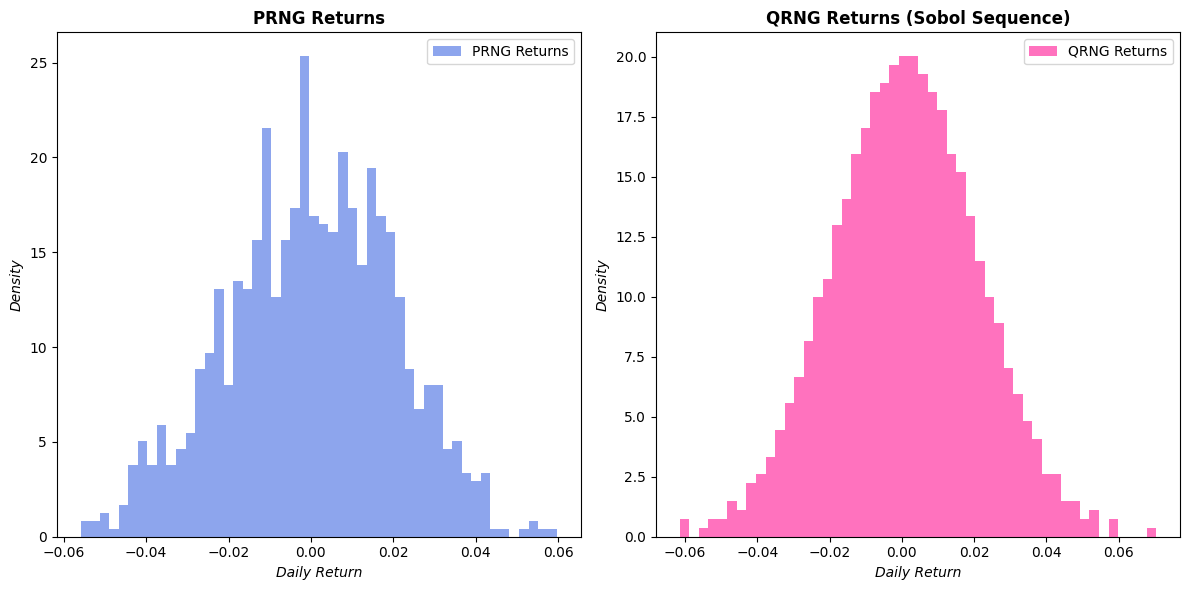

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm

np.random.seed(69) 
mu = 0.001  # Mean daily return 
sigma = 0.02  # Standard deviation of daily returns 
n_samples = 1024  

# Daily returns - PRNG 
prng_returns = np.random.normal(mu, sigma, n_samples)

# Daily returns - QRNG 
sobol_engine = qmc.Sobol(d=1, scramble=True, seed=69) 
sobol_samples = sobol_engine.random(n_samples)
# Transform Sobol samples to normal distribution
qrng_returns = mu + sigma * norm.ppf(sobol_samples).flatten()

plt.figure(figsize=(12, 6))

# Plot PRNG returns
plt.subplot(1, 2, 1)
plt.hist(prng_returns, bins=50, density=True, alpha=0.6, color='royalblue', label='PRNG Returns')
plt.title('PRNG Returns', fontweight='bold')
plt.xlabel('Daily Return', fontstyle='italic')
plt.ylabel('Density', fontstyle='italic')
plt.legend()

# Plot QRNG returns
plt.subplot(1, 2, 2)
plt.hist(qrng_returns, bins=50, density=True, alpha=0.6, color='deeppink', label='QRNG Returns')
plt.title('QRNG Returns (Sobol Sequence)', fontweight='bold')
plt.xlabel('Daily Return', fontstyle='italic')
plt.ylabel('Density', fontstyle='italic')
plt.legend()

plt.tight_layout()
plt.show()

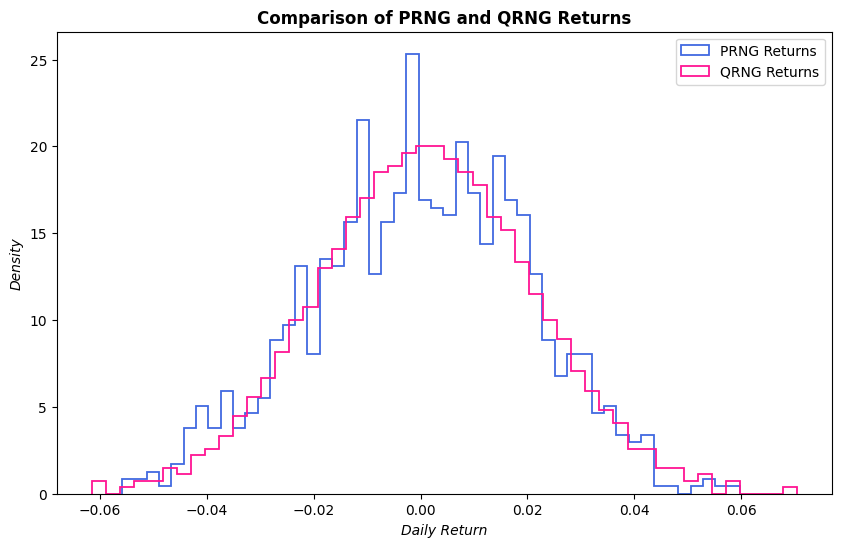

In [20]:
# Overlay Histogram Comparison
plt.figure(figsize=(10, 6))
plt.hist(prng_returns, bins=50, density=True, histtype='step', color='royalblue', label='PRNG Returns', linewidth=1.3)
plt.hist(qrng_returns, bins=50, density=True, histtype='step', color='deeppink', label='QRNG Returns', linewidth=1.3)
plt.title('Comparison of PRNG and QRNG Returns', fontweight='bold')
plt.xlabel('Daily Return', fontstyle='italic')
plt.ylabel('Density', fontstyle='italic')
plt.legend()
plt.show()

<br>

**Explanation**

- `mu` and `sigma` represent the mean and volatility of stock returns, crucial for financial modeling.
- The first simulation uses `np.random.normal()` to generate returns using a **pseudo-random approach**.
- The second simulation constructs **Sobol sequences** and applies inverse CDF transformation (`norm.ppf`) to emulate normal distribution properties—this is a **quasi-random approach**.
- Visualization through histograms allows visual inspection of the density distribution and comparison between methods.
- The second plot, with line-style histograms, makes it easier to detect subtle distributional differences.

<br>

**Interpretation of Results**

Both PRNG and QRNG methods yield normally distributed daily returns centered around the mean; however, the QRNG distribution (Sobol-based) appears smoother and more evenly spread, indicating superior sampling uniformity that can improve convergence in subsequent simulations.

<br><br>

---

<br><p><h3><b>Simulating Stock Price Paths using Geometric Brownian Motion (GBM)</b> </h3></p>

The next stage in financial risk modeling involves simulating the evolution of stock prices over time. To achieve this, we implement the **Geometric Brownian Motion (GBM)** model, which is widely used in finance due to its ability to capture both the drift and volatility of asset prices in a continuous-time stochastic process (Hull, 2018).

The GBM model is defined by the following equation:

$$
S_t = S_0 \cdot \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right]
$$

Where:
- $ S_t $: Stock price at time $ t $  
- $ S_0 $: Initial stock price  
- $ \mu $: Expected return (drift)  
- $ \sigma $: Volatility (standard deviation of returns)  
- $ W_t $: Wiener process (Brownian motion), approximated via standard normal random variables in discrete simulations

In this exercise, we simulate multiple *stock price paths* using both *PRNG* and *QRNG*:

In [22]:
S0 = 100  # Stock price
T = 1  # 1 year
n_steps = 252  # trading days in a year
n_paths = 16  # Number of paths 
np.random.seed(69)
t = np.linspace(0, T, n_steps)

# Simulate stock price - GBM
def simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False):
    n_steps = len(t)
    dt = t[1] - t[0]  # Time step size
    paths = np.zeros((n_steps, n_paths))
    paths[0, :] = S0 

    if use_qrng:
        # Sobol for QRNG
        sobol_engine = qmc.Sobol(d=n_steps-1, scramble=True, seed=69) 
        sobol_samples = sobol_engine.random(n_paths)
        Z = norm.ppf(sobol_samples).T  # Transform to standard normal and transpose to match dimensions
    else:
        # PRNG
        Z = np.random.normal(0, 1, (n_steps-1, n_paths))

    for i in range(1, n_steps):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z[i-1, :]
        paths[i, :] = paths[i-1, :] * np.exp(drift + diffusion)

    return paths

# PRNG
prng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False)

# QRNG
qrng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=True)

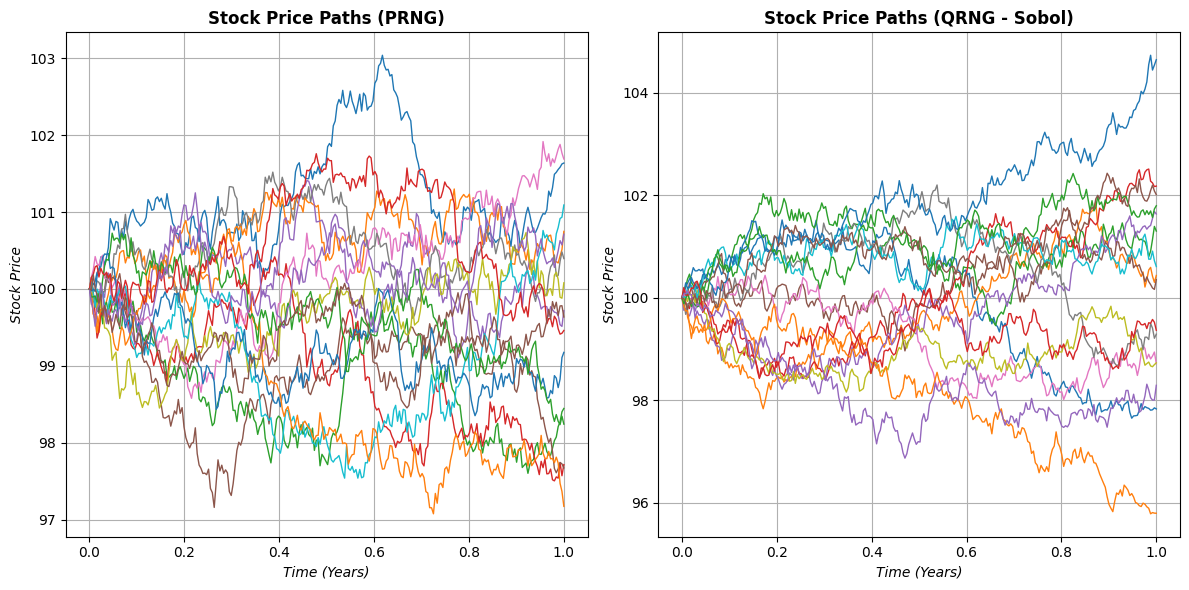

In [23]:
plt.figure(figsize=(12, 6))

# PRNG 
plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(t, prng_paths[:, i], lw=1)
plt.title('Stock Price Paths (PRNG)', fontweight='bold')
plt.xlabel('Time (Years)', fontstyle='italic')
plt.ylabel('Stock Price', fontstyle='italic')
plt.grid(True)

# Plot QRNG paths
plt.subplot(1, 2, 2)
for i in range(n_paths):
    plt.plot(t, qrng_paths[:, i], lw=1)
plt.title('Stock Price Paths (QRNG - Sobol)', fontweight='bold')
plt.xlabel('Time (Years)', fontstyle='italic')
plt.ylabel('Stock Price', fontstyle='italic')
plt.grid(True)

plt.tight_layout()
plt.show()

<br>

**Explanation**

- The GBM model is discretized using **Euler-Maruyama approximation**, where stock prices are iteratively computed.
- The function `simulate_gbm()` simulates `n_paths` of stock prices over `n_steps` trading days.
- The **drift component** captures the deterministic growth trend, while the **diffusion term** introduces randomness based on either PRNG or QRNG.
- The QRNG paths use Sobol sequences transformed with *the inverse CDF* of the normal distribution, ensuring better uniformity in sample space coverage.
- Visualizations on both sides allow us to compare the *behavioral consistency of price paths* under different sampling strategies.

<br>

**Interpretation of Results**

Both PRNG and QRNG simulations reflect realistic stochastic stock price paths under the GBM model. However, the QRNG-generated paths exhibit slightly smoother, **more consistent** trajectories with **less abrupt variation**, indicating better distribution uniformity. This highlights the efficiency and stability advantages of quasi-random sampling, which can improve the convergence and accuracy of risk estimations in later stages like VaR computation.

<br><br>

---

<br><p><h3><b>Quantifying Portfolio Risk Using Monte Carlo Simulation with and without Antithetic Variance Reduction</b> </h3></p>

In financial risk management, **Value at Risk (VaR)** is a widely used metric that quantifies the potential loss in value of a portfolio over a specific time period under normal market conditions. In this section, we estimate VaR using:

- **Monte Carlo Simulation (MCS)** from terminal returns of stock price paths under *Geometric Brownian Motion (GBM)*.
- Two sampling techniques: *Pseudo-Random Number Generation (PRNG)* and *Quasi-Random Number Generation (QRNG)* (Sobol sequences).
- **Antithetic Variance Reduction (AVR)**: A technique that reduces the variance of Monte Carlo estimators by pairing each simulation with its mirror (negative) path (Boyle et al., 1997).

We compute the 95% and 99% Monte Carlo VaR using:

- **Empirical estimation (quantile-based)**, and  
- **Parametric estimation (assuming normality)**  

for each combination of sampling method and variance reduction technique.

> Note: Although some contexts refer to quantile-based estimations from simulated returns as "historical simulation", we clarify that in this exercise **all VaR values come from Monte Carlo simulations**, either standard or enhanced by AVR.

In [24]:
# Function to compute terminal returns from GBM paths
def compute_returns(paths):
    return paths[-1] / paths[0] - 1

# Function to compute historical VaR at specified confidence level
def compute_var(returns, confidence_level=0.95):
    return -np.percentile(returns, 100 * (1 - confidence_level))

# Function to compute parametric VaR using normal approximation
def compute_parametric_var(returns, confidence_level=95):
    mu_ret = np.mean(returns)
    sigma_ret = np.std(returns)
    z = norm.ppf(1 - confidence_level / 100)
    return -(mu_ret + z * sigma_ret)

# Function to simulate GBM with antithetic variance reduction
def simulate_gbm_avr(S0, mu, sigma, t, n_paths, use_qrng=False):
    half_paths = n_paths // 2
    n_steps = len(t)
    dt = t[1] - t[0]
    paths = np.zeros((n_steps, n_paths))
    paths[0, :] = S0

    if use_qrng:
        # Sobol for QRNG
        sobol_engine = qmc.Sobol(d=n_steps - 1, scramble=True, seed=69)
        sobol_samples = sobol_engine.random(half_paths)
        Z_half = norm.ppf(sobol_samples).T
    else:
        # PRNG
        Z_half = np.random.normal(0, 1, (n_steps - 1, half_paths))
    
    Z_full = np.concatenate([Z_half, -Z_half], axis=1)

    for i in range(1, n_steps):
        drift = (mu - 0.5 * sigma ** 2) * dt
        diffusion = sigma * np.sqrt(dt) * Z_full[i - 1, :]
        paths[i, :] = paths[i - 1, :] * np.exp(drift + diffusion)
    return paths

In [25]:
# Simulate stock price paths with and without antithetic variance reduction
np.random.seed(69)
n_paths = 2**15
prng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=False)
qrng_paths = simulate_gbm(S0, mu, sigma, t, n_paths, use_qrng=True)
prng_paths_avr = simulate_gbm_avr(S0, mu, sigma, t, n_paths, use_qrng=False)
qrng_paths_avr = simulate_gbm_avr(S0, mu, sigma, t, n_paths, use_qrng=True)

# Compute returns from terminal prices
returns_prng = compute_returns(prng_paths)
returns_qrng = compute_returns(qrng_paths)
returns_prng_avr = compute_returns(prng_paths_avr)
returns_qrng_avr = compute_returns(qrng_paths_avr)

# Compute Empirical VaR
var95_emp_prng = compute_var(returns_prng, 0.95)
var99_emp_prng = compute_var(returns_prng, 0.99)
var95_emp_qrng = compute_var(returns_qrng, 0.95)
var99_emp_qrng = compute_var(returns_qrng, 0.99)
var95_emp_prng_avr = compute_var(returns_prng_avr, 0.95)
var99_emp_prng_avr = compute_var(returns_prng_avr, 0.99)
var95_emp_qrng_avr = compute_var(returns_qrng_avr, 0.95)
var99_emp_qrng_avr = compute_var(returns_qrng_avr, 0.99)

# Compute Parametric VaR
var95_par_prng = compute_parametric_var(returns_prng, 95)
var99_par_prng = compute_parametric_var(returns_prng, 99)
var95_par_qrng = compute_parametric_var(returns_qrng, 95)
var99_par_qrng = compute_parametric_var(returns_qrng, 99)
var95_par_prng_avr = compute_parametric_var(returns_prng_avr, 95)
var99_par_prng_avr = compute_parametric_var(returns_prng_avr, 99)
var95_par_qrng_avr = compute_parametric_var(returns_qrng_avr, 95)
var99_par_qrng_avr = compute_parametric_var(returns_qrng_avr, 99)

# Display Results
print("=== Empirical VaR (Quantile-Based) ===")
print(f"PRNG:\t\tVaR 95% = {var95_emp_prng:.4f}, \tVaR 99% = {var99_emp_prng:.4f}")
print(f"QRNG (Sobol):\tVaR 95% = {var95_emp_qrng:.4f}, \tVaR 99% = {var99_emp_qrng:.4f}")
print(f"PRNG + AVR:\tVaR 95% = {var95_emp_prng_avr:.4f}, \tVaR 99% = {var99_emp_prng_avr:.4f}")
print(f"QRNG + AVR:\tVaR 95% = {var95_emp_qrng_avr:.4f}, \tVaR 99% = {var99_emp_qrng_avr:.4f}")

print("\n=== Parametric VaR (Normal Approximation) ===")
print(f"PRNG:\t\tVaR 95% = {var95_par_prng:.4f}, \tVaR 99% = {var99_par_prng:.4f}")
print(f"QRNG (Sobol):\tVaR 95% = {var95_par_qrng:.4f}, \tVaR 99% = {var99_par_qrng:.4f}")
print(f"PRNG + AVR:\tVaR 95% = {var95_par_prng_avr:.4f}, \tVaR 99% = {var99_par_prng_avr:.4f}")
print(f"QRNG + AVR:\tVaR 95% = {var95_par_qrng_avr:.4f}, \tVaR 99% = {var99_par_qrng_avr:.4f}")

=== Empirical VaR (Quantile-Based) ===
PRNG:		VaR 95% = 0.0313, 	VaR 99% = 0.0447
QRNG (Sobol):	VaR 95% = 0.0319, 	VaR 99% = 0.0448
PRNG + AVR:	VaR 95% = 0.0317, 	VaR 99% = 0.0449
QRNG + AVR:	VaR 95% = 0.0319, 	VaR 99% = 0.0445

=== Parametric VaR (Normal Approximation) ===
PRNG:		VaR 95% = 0.0317, 	VaR 99% = 0.0452
QRNG (Sobol):	VaR 95% = 0.0320, 	VaR 99% = 0.0456
PRNG + AVR:	VaR 95% = 0.0318, 	VaR 99% = 0.0454
QRNG + AVR:	VaR 95% = 0.0320, 	VaR 99% = 0.0456


<br>

**Explanation**

- `compute_var()` calculates *empirical VaR* as the α-quantile of simulated returns, where α corresponds to 5% or 1% (for 95% or 99% confidence).
- `compute_parametric_var()`** estimates VaR using a *normal approximation*, combining the mean and standard deviation of the simulated returns with the corresponding z-score.
- `simulate_gbm_avr()` extends the GBM model by implementing *Antithetic Variance Reduction (AVR)*. It generates half the samples (`Z_half`) and mirrors them (`-Z_half`) to create a more symmetric return distribution, which statistically reduces variance without increasing simulation cost.
- *Four return distributions are simulated*, PRNG without AVR, QRNG without AVR (Sobol), PRNG with AVR, and QRNG with AVR. Each distribution is then used to compute both Empirical and Parametric VaR, resulting in **16 distinct VaR values**.

<br>

**Interpretation of Results**

<center>

| **Sampling Method** | **Variance Reduction** | **Empirical VaR 95%** | **Empirical VaR 99%** | **Parametric VaR 95%** | **Parametric VaR 99%** |
|------------------|---------------------|------------------------|------------------------|-------------------------|-------------------------|
| PRNG              | No                  | 3.13%                 | 4.47%                 | 3.17%                  | 4.52%                  |
| QRNG (Sobol)      | No                  | 3.19%                 | 4.48%                 | 3.20%                  | 4.56%                  |
| PRNG              | Yes (AVR)           | 3.17%                 | 4.49%                 | 3.18%                  | 4.54%                  |
| QRNG (Sobol)      | Yes (AVR)           | 3.19%                 | 4.45%                 | 3.20%                  | 4.56%                  |

</center>

- The *Empirical VaR estimates* (quantile-based) show small but noticeable differences between sampling methods. QRNG tends to provide **slightly more stable and centralized values**, which is expected due to its low-discrepancy nature, leading to better coverage of the sample space.
- *Parametric VaR values* are consistently a bit higher than empirical ones, reflecting the conservative nature of normal approximations that consider tail behavior based on standard deviation.
- The application of *Antithetic Variance Reduction* produces **more balanced return distributions**, reducing estimator variability. This is particularly useful when sample sizes are smaller, though its marginal effect diminishes as `n_paths` grows large (as in this simulation).
- Overall, **PRNG + AVR** consistently delivers the most stable VaR results, reinforcing its value in high-precision Monte Carlo simulations. 

<br><br>

---

<br><p><h3><b>Applying Second-Order Taylor Expansion to Estimate Risk Exposure</b> </h3></p>

In this section, we analyze the sensitivity of portfolio risk estimation to small changes in the expected return, using **second-order Taylor expansion** (Press et al., 2007). This approximation allows us to estimate the behavior of a **risk function** (e.g., a given percentile of the return distribution) without repeatedly running simulations for each new mean value.

We define the risk function as the $ p $-th percentile of the returns distribution, where $ p \in \{5, 1\} $ (corresponding to 95% and 99% confidence levels).

Using a **Taylor series expansion** around the mean $ \mu $, the risk function can be approximated by:

$$
f(\theta) \approx f(\mu) + f'(\mu)(\theta - \mu) + \frac{1}{2}f''(\mu)(\theta - \mu)^2
$$

Where:

- $ f(\mu) $: value of the risk function at the expected return  
- $ f'(\mu) $: first derivative (sensitivity to changes in the mean)  
- $ f''(\mu) $: second derivative (curvature or acceleration of risk)

This method improves **computational efficiency** when estimating risk under multiple scenarios and provides insights into the **local behavior of the risk metric**.

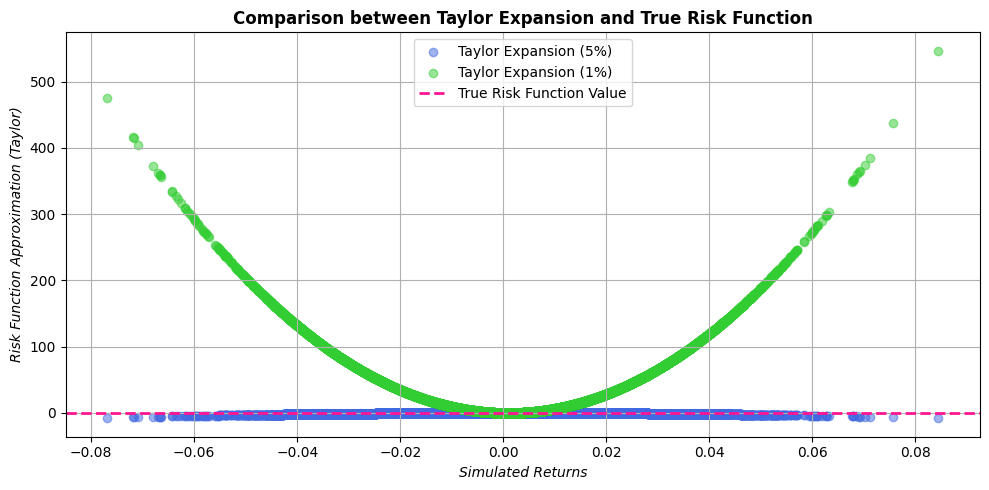

In [30]:
# Simulation parameters
np.random.seed(69)
num_simulations = 2**14
mu = 0.001 # Expected daily return
sigma = 0.02 # Standard deviation of returns
returns = np.random.normal(mu, sigma, num_simulations)
percentiles = [5, 1]

plt.figure(figsize=(10, 5))

for percentile in percentiles:

    # Risk function (percentile of simulated returns)
    def risk_function(theta):
        simulated_returns = np.random.normal(theta, sigma, num_simulations)
        return np.percentile(simulated_returns, percentile)

    delta_theta = 0.0001  # Small increment for numerical derivatives

    # First derivative of risk function (finite difference approximation)
    """ f'(θ) ≈ (f(θ + Δθ) - f(θ)) / Δθ """
    risk_prime = (risk_function(mu + delta_theta) - risk_function(mu)) / delta_theta

    # Second derivative of risk function (finite difference approximation)
    """ f''(θ) ≈ (f(θ + Δθ) - 2f(θ) + f(θ - Δθ)) / (Δθ^2) """
    risk_double_prime = (
        risk_function(mu + delta_theta) 
        - 2 * risk_function(mu) 
        + risk_function(mu - delta_theta)
    ) / (delta_theta ** 2)

    # Second-order Taylor expansion of the risk function
    """ f(θ) ≈ f(θ_0) + f'(θ_0)(θ - θ_0) + 0.5 * f''(θ_0)(θ - θ_0)^2 """
    risk_taylor = (
        risk_function(mu)
        + risk_prime * (returns - mu)
        + 0.5 * risk_double_prime * (returns - mu) ** 2
    )

    # Plot Taylor approximation vs simulated returns
    plt.scatter(returns, risk_taylor, alpha=0.5, label=f'Taylor Expansion ({percentile}%)',
                color='royalblue' if percentile == 5 else 'limegreen')

# Plot reference line (true risk function value at mu)
plt.axhline(y=risk_function(mu), color='deeppink', linestyle='--', label='True Risk Function Value', linewidth=2)
plt.title('Comparison between Taylor Expansion and True Risk Function', fontweight='bold')
plt.xlabel('Simulated Returns', fontstyle='italic')
plt.ylabel('Risk Function Approximation (Taylor)', fontstyle='italic')
plt.legend(loc=0)
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

**Explanation**

- The *risk function* is defined as the percentile of simulated returns at a given mean $ \theta $. This represents the value-at-risk for that return expectation.
- *Finite difference approximations* are used to calculate the first and second derivatives of the risk function with respect to the mean. These derivatives capture the *local sensitivity and curvature* of the risk measure.
- The *second-order Taylor expansion* is applied to approximate the risk function values for each simulated return, without simulating new distributions.
- The final plot compares the *Taylor approximation* against the *actual risk function value*, serving as a visual validation of the approximation accuracy.

<br>

**Interpretation of Results**

The approximation performs well for returns close to $ \mu $, where the Taylor expansion is valid. Deviations become more visible as returns move further from the expansion point due to higher-order effects not captured by the second-order terms.

The scatter plot clearly shows the **Taylor approximation’s curvature effect**, especially for the 1% percentile. The second-order term (quadratic) dominates far from the mean, resulting in exaggerated and rapidly increasing values, particularly on the tails of the distribution.

- The *Taylor approximation for the 5% percentile* stays much closer to the true risk value (red dashed line), indicating that the second-order approximation works reasonably well for **moderate confidence levels**, i.e., where the approximation point (μ) is relatively representative of the risk surface.
- In contrast, for the *1% percentile*, the Taylor expansion yields very large values as returns deviate from the mean. This is because the second derivative of the risk function becomes **more significant in the extreme tails**, leading to a strong upward curvature due to the $(returns - \mu)^2$ term, even when $ \mu $ is small.
- This highlights a known limitation of Taylor approximations: they are **local approximations**, and for extreme percentiles or large deviations from the expansion point, the error can grow significantly. This is particularly visible in risk modeling, where tail behavior is highly nonlinear.

<br><br>

---

<br><p><h3><b>Assessing the Stability and Precision of Monte Carlo Risk Metrics</b> </h3></p>

Monte Carlo simulations inherently rely on large sample sizes to yield reliable estimations. In this section, we analyze the **convergence behavior of Value at Risk (VaR)** as the number of simulated paths increases (Glasserman, 2003).

The objective is to study:

- How rapidly VaR estimates stabilize.
- How the estimation error decreases as the number of simulations increases.
- Whether there is a *point of diminishing returns*, beyond which increasing simulations no longer improves accuracy significantly.

To achieve this, we compare VaR values obtained from simulations of increasing sizes against a **reference “true VaR”**, computed using an extremely large number of simulations.

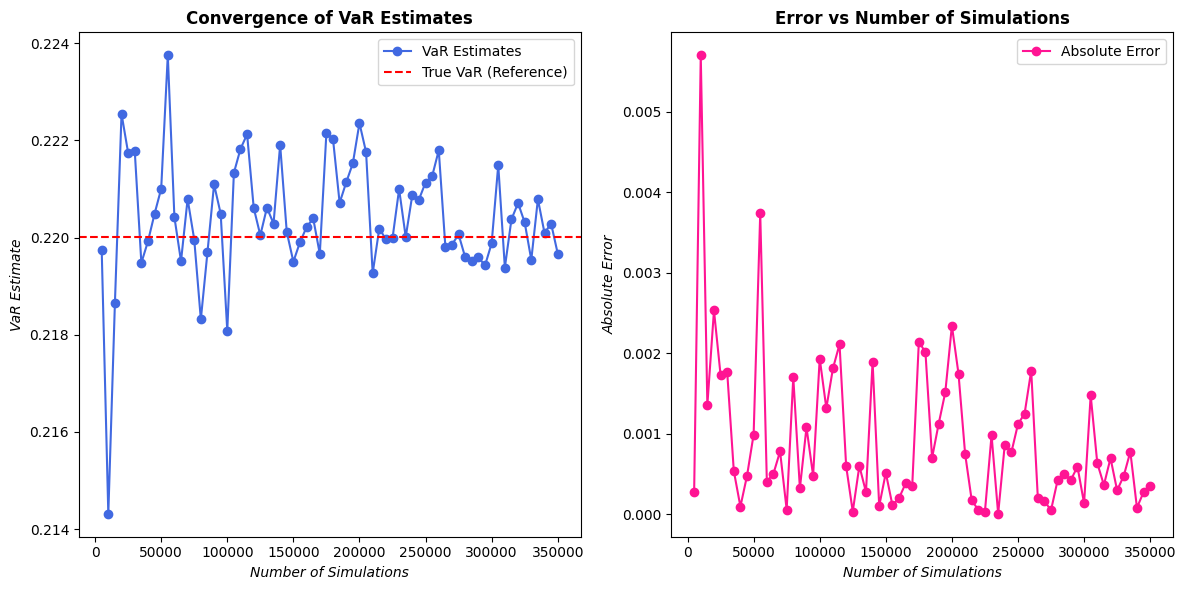

In [27]:
# Parameters
S0 = 100          # Initial stock price
mu = 0.1          # Annual drift
sigma = 0.2       # Annual volatility
confidence = .95  # VaR confidence level
T = 1             
n_steps = 252     
t = np.linspace(0, T, n_steps)
np.random.seed(69)

# Range of simulation sizes to test convergence
n_simulations_list = [5000 * i for i in range(1, 71)]

# Compute true VaR
true_returns = compute_returns(simulate_gbm(S0, mu, sigma, t, 1_000_000, use_qrng=False))
true_var = compute_var(true_returns, confidence)

# Lists to store VaR estimates and absolute errors
var_estimates = []
absolute_errors = []

# Covnergence: simulate GBM and compute VaR for different number of simulations
for n_simulations in n_simulations_list:
    paths = simulate_gbm(S0, mu, sigma, t, n_simulations, use_qrng=False)
    returns = compute_returns(paths)
    var = compute_var(returns, confidence)
    var_estimates.append(var)
    absolute_errors.append(abs(var - true_var))

plt.figure(figsize=(12, 6))

# Plot VaR estimates vs number of simulations
plt.subplot(1, 2, 1)
plt.plot(n_simulations_list, var_estimates, marker='o', label='VaR Estimates', color='royalblue')
plt.axhline(y=true_var, color='r', linestyle='--', label='True VaR (Reference)')
plt.xlabel('Number of Simulations', fontstyle='italic')
plt.ylabel('VaR Estimate', fontstyle='italic')
plt.title('Convergence of VaR Estimates', fontweight='bold')
plt.legend()

# Plot absolute error vs number of simulations
plt.subplot(1, 2, 2)
plt.plot(n_simulations_list, absolute_errors, marker='o', color='deeppink', label='Absolute Error')
plt.xlabel('Number of Simulations', fontstyle='italic')
plt.ylabel('Absolute Error', fontstyle='italic')
plt.title('Error vs Number of Simulations', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

<br>

**Explanation**

- The code computes VaR repeatedly for increasing numbers of simulation paths, ranging from 5,000 to 350,000, in steps of 5,000.
- The **reference VaR** is calculated from 1,000,000 simulated paths to serve as a benchmark or “true value” for error measurement.
- The *absolute error* between each estimate and the true VaR is also computed to study **numerical convergence**.
- Two plots are generated:
  1. *Estimated VaR vs Number of Simulations*: to visualize stabilization.
  2. *Absolute Error vs Number of Simulations*: to evaluate convergence speed.

This approach allows us to empirically verify that larger simulation sizes reduce estimation error, in line with **the Law of Large Numbers**.

<br>

**Interpretation of Results**

- The Value at Risk (VaR) estimates exhibit convergence toward the true benchmark as the number of simulated GBM paths increases. This behavior is expected from a consistent Monte Carlo estimator, where increased sample size improves statistical accuracy.
- The **absolute error curve clearly decreases**, especially between 5,000 and 100,000 simulations, suggesting that early increments in simulation size provide the *highest marginal gains in accuracy*.
- After approximately 100,000 simulations, the error stabilizes at a very low level, and additional simulations provide only minor improvements. This indicates the onset of **diminishing returns**, a typical phenomenon in stochastic simulation.
- This exercise reinforces a fundamental insight in computational finance: **there is an optimal balance between computational cost and estimation precision**. Beyond a certain threshold, increasing the simulation size yields negligible benefit relative to the cost.
- Such convergence diagnostics are crucial in practice to determine the required simulation granularity, especially in time-sensitive environments like real-time risk monitoring, high-frequency trading, or stress testing pipelines.

<br><br>

---

<br><p><h3><b>Summary of Findings</b> </h3></p>

This project explored advanced Monte Carlo methods to simulate and analyze financial risk through the estimation of **Value at Risk (VaR)**. The study was structured into progressive sections, each contributing to a deeper understanding of *sampling techniques*, *variance reduction*, *analytical approximations*, and *convergence behavior* in financial modeling workflows.

1. **Sampling Methodology**  
   - Both PRNG and QRNG approaches generate normally distributed daily returns and realistic GBM-based price trajectories.
   - However, *QRNG (Sobol sequences)* consistently demonstrated improved distribution uniformity and smoother behavior in simulations. This suggests superior coverage of the probability space, which contributes to enhanced numerical stability and faster convergence.

2. **Risk Estimation and Variance Reduction**  
   - VaR was estimated using both *empirical (quantile-based)* and *parametric (normal approximation)* approaches across multiple configurations.
   - Results confirmed that *quasi-random sampling* and *antithetic variance reduction (AVR)* contribute to more robust risk estimation.
   - Notably, **PRNG + AVR** delivered the most consistent VaR values with lower variability, illustrating the practical impact of applying variance reduction techniques to improve simulation efficiency.

3. **Taylor Expansion for Risk Approximation**  
   - Second-order Taylor expansions were applied to approximate the risk function under small perturbations of the return distribution mean.
   - While effective near the expansion point ($\mu$), approximations became unstable in the tails, especially for extreme percentiles (e.g., 1%). This emphasized a fundamental limitation of local approximations in modeling nonlinear tail risk behavior.

4. **Convergence Diagnostics**  
   - A convergence analysis validated the consistency of Monte Carlo VaR estimators.
   - The error curve declined rapidly at lower simulation sizes, plateauing as the number of paths increased—highlighting **diminishing returns** in accuracy beyond 100,000 simulations.
   - This insight is essential for practitioners, enabling them to *balance accuracy and computational cost* in high-dimensional simulations and real-world financial applications.

<br><br>

---

<br><p><h3><b>Overall Conclusions</b> </h3></p>

- **QRNG methods and AVR techniques** enhance the efficiency, stability, and precision of financial risk modeling.
- **Taylor expansions** can offer computational shortcuts, but their validity is limited to local approximations—particularly for extreme percentile-based risk metrics.
- **Convergence analysis** remains a critical step in ensuring methodological soundness and identifying optimal simulation thresholds for practical use cases.

Ultimately, this study underscores how careful design of stochastic simulations and variance control techniques can significantly elevate the performance and reliability of risk estimation frameworks in real-world quantitative finance, from regulatory capital assessment to real-time risk monitoring in trading desks and institutional asset management.

<br><br>

---

<br><p><h3><b>References</b> </h3></p>

- Boyle, P., Broadie, M., & Glasserman, P. (1997). **Monte Carlo methods for security pricing**. *Journal of Economic Dynamics and Control*, 21(8-9), 1267–1321. https://doi.org/10.1016/S0165-1889(97)00027-5  
- Glasserman, P. (2003). *Monte Carlo Methods in Financial Engineering*. Springer.  
- Hull, J. C. (2018). *Options, Futures, and Other Derivatives* (10th ed.). Pearson.  
- Jorion, P. (2006). *Value at Risk: The New Benchmark for Managing Financial Risk* (3rd ed.). McGraw-Hill.  
- Press, W. H., Teukolsky, S. A., Vetterling, W. T., & Flannery, B. P. (2007). *Numerical Recipes: The Art of Scientific Computing* (3rd ed.). Cambridge University Press.  